In [1]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/content/drive/MyDrive/cleaned_output/Training"
test_dir="/content/drive/MyDrive/cleaned_output/Testing"

In [4]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*"))
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

4 Classes
5712 Train images
1311 Test images


In [5]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
     fill_mode='nearest',
    horizontal_flip=True,
     vertical_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [6]:
input_shape=(256,256,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(256,256),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(256,256),batch_size=32)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
IMAGE_SIZE = [256, 256]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# We don't need to train existing weights
for layer in inception.layers:
    layer.trainable = False

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

IMAGE_SIZE = [256, 256]

# Load the InceptionV3 model with weights pre-trained on ImageNet
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the existing weights
for layer in inception.layers:
    layer.trainable = False

# Add your own classification head to the model
x = GlobalAveragePooling2D()(inception.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create a new model with the InceptionV3 base and your classification head
model = Model(inputs=inception.input, outputs=output)

# Compile the model (add optimizer, loss function, etc. based on your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalization_94[0

In [9]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(256, 256),
                       batch_size=32)

Found 1311 images belonging to 4 classes.


In [10]:
history = model.fit(train_generator,
                      steps_per_epoch=None,
                      epochs=30,
                      validation_data=validation_generator,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.001)],
                      use_multiprocessing=False,
                      shuffle=True)

Epoch 1/30
179/179 [==============================] - 1298s 7s/step - loss: 0.6121 - accuracy: 0.7624 - val_loss: 0.5643 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 2/30
179/179 [==============================] - 1274s 7s/step - loss: 0.4052 - accuracy: 0.8512 - val_loss: 0.4957 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 3/30
179/179 [==============================] - 1263s 7s/step - loss: 0.3614 - accuracy: 0.8645 - val_loss: 0.4197 - val_accuracy: 0.8398 - lr: 0.0010
Epoch 4/30
179/179 [==============================] - 1262s 7s/step - loss: 0.3346 - accuracy: 0.8787 - val_loss: 0.4889 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 5/30
179/179 [==============================] - 1264s 7s/step - loss: 0.3373 - accuracy: 0.8746 - val_loss: 0.4687 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 6/30
179/179 [==============================] - 1234s 7s/step - loss: 0.2984 - accuracy: 0.8916 - val_loss: 0.3575 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 7/30
179/179 [==============================] - 1231

In [11]:
result = model.evaluate(train_generator)
dict(zip(model.metrics_names, result))

179/179 [==============================] - 998s 6s/step - loss: 0.1870 - accuracy: 0.9245


{'loss': 0.18695949018001556, 'accuracy': 0.9245448112487793}

In [12]:
result = model.evaluate(validation_generator)
dict(zip(model.metrics_names, result))

41/41 [==============================] - 228s 6s/step - loss: 0.3036 - accuracy: 0.8879


{'loss': 0.30356451869010925, 'accuracy': 0.8878718614578247}

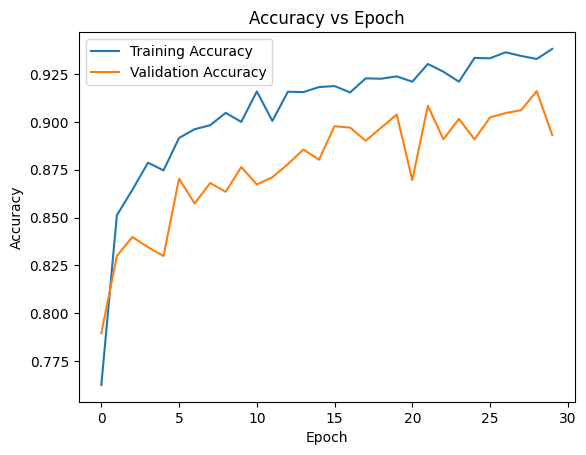

In [13]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

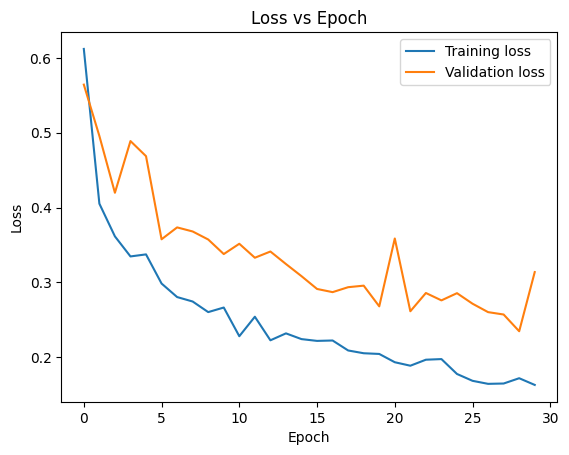

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

41/41 [==============================] - 232s 6s/step


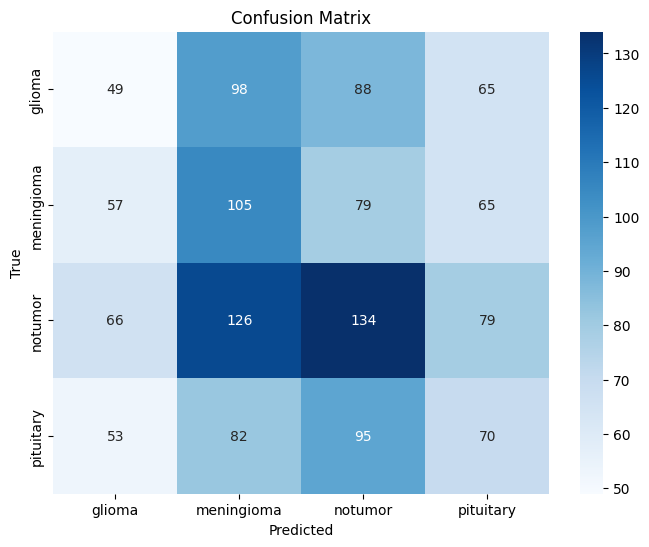

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `model` is your trained model
# Assuming `validation_generator` contains validation data and labels

# Make predictions on the validation set
predictions = model.predict(validation_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Obtain true labels from the validation generator
true_labels = validation_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
class_names = validation_generator.class_indices.keys()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Assuming test_dir is the path to your validation data directory
validation_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # Adjust this based on your problem (binary or multiclass)
    shuffle=False  # Keep the order for evaluation
)

# Assuming model is your trained model
# Assuming history and plt are already defined in your code

# Make predictions on the validation set
predictions = model.predict(validation_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Obtain true labels from the validation generator
true_labels = validation_generator.classes

# Calculate precision, recall, and F1-score
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Found 1311 images belonging to 4 classes.
41/41 [==============================] - 231s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       300
           1       0.71      0.95      0.81       306
           2       0.98      0.96      0.97       405
           3       0.96      0.88      0.92       300

    accuracy                           0.89      1311
   macro avg       0.90      0.88      0.89      1311
weighted avg       0.91      0.89      0.89      1311

